In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

In [2]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 48 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 
--encoder_architecture cnn_gap_ts --encoder_features 20 --mode clr --cf 0.001 --label_mode 48 --mode clr3'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 48
[4 4 4 ... 1 1 1] [ 0  1  2  3  4  5  6  7  8  9 10 11]
Using 619292 observations for training, 106617 for validation and 143333 observations for test


In [8]:
res = dm.ds_train[0]

14749 255467


In [4]:
len(dm.ds_train.clr_indices)

12

In [5]:
res["label"]

tensor(4)

In [51]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="training_clr/clr_UCI-HAR_21-20-19-18-17_4_48_1_bs128_lr0.01_l10_l20_cnn_gap_ts10_mlpNone_1_m48/version_0/checkpoints/epoch=6-step=33873-val_re=0.0000.ckpt")

Input shape:  torch.Size([1, 6, 48])
Latent shape:  torch.Size([1, 40])


In [64]:
labels = []

for i in range(0, 10000):
    labels.append(dm.ds_test[i]["label"].item())

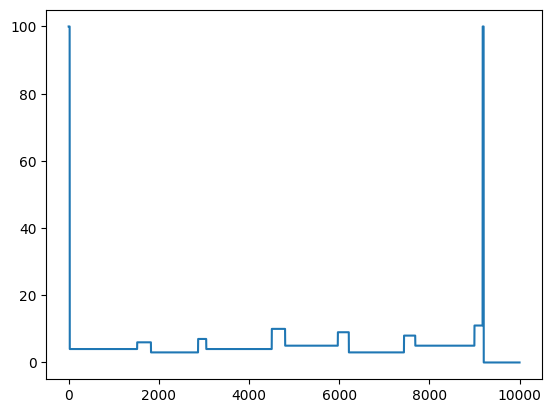

In [65]:
plt.plot(labels)

In [59]:
scores = []

ws = 48
for i in range(0, 10000):
    prev = dm.ds_test[i]["series"]
    next = dm.ds_test[i+ws]["series"]

    prev_rep = model(prev.unsqueeze(0))
    next_rep = model(next.unsqueeze(0))

    scores.append((prev_rep-next_rep).square().sum().sqrt().item())

(-0.15, 13.15)

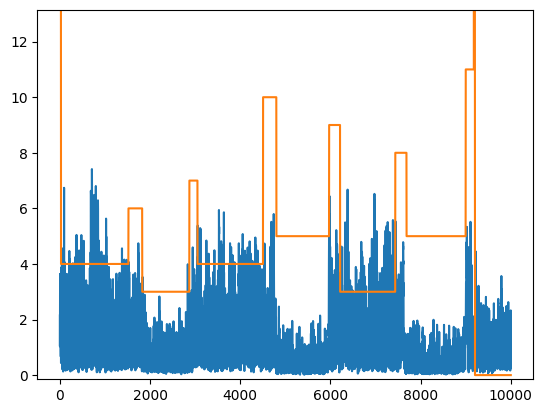

In [66]:
plt.plot(np.arange(len(scores)), scores, np.arange(len(labels)), labels)
plt.ylim([-.15, 13.15])